Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import geopandas as gpd
from shapely.geometry import Point
import pyarrow.parquet as pq

Uploading Data

In [2]:
from google.colab import files
import pandas as pd
import pyarrow.parquet as pq

# Upload the Parquet file
#uploaded = files.upload()

# Assuming you uploaded the file with the name 'fhvhv_tripdata_2021-01.parquet'
file_name = 'fhvhv_tripdata_2021-01.parquet'

# Load trip data from the uploaded Parquet file
trip_data = pq.read_table(file_name).to_pandas()

# Load taxi zone lookup data (assuming it's also uploaded to Colab)
taxi_zone_lookup = pd.read_csv('/content/taxi_zone_lookup.csv')


Knowing trip colums for better knowledge of data

In [4]:
print(trip_data.columns)


Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag'],
      dtype='object')


**Exploratory Data Analaysis**

In [5]:
# Merge trip data with taxi zone lookup based on pickup location
trip_data = trip_data.merge(taxi_zone_lookup, how='left', left_on='PULocationID', right_on='LocationID', suffixes=('', '_pickup'))

# Merge trip data with taxi zone lookup based on dropoff location
trip_data = trip_data.merge(taxi_zone_lookup, how='left', left_on='DOLocationID', right_on='LocationID', suffixes=('', '_dropoff'))


In [6]:
# Convert date columns to datetime
trip_data['pickup_datetime'] = pd.to_datetime(trip_data['pickup_datetime'])
trip_data['dropoff_datetime'] = pd.to_datetime(trip_data['dropoff_datetime'])

# Calculate trip duration in minutes
trip_data['trip_duration_minutes'] = (trip_data['dropoff_datetime'] - trip_data['pickup_datetime']).dt.total_seconds() / 60

# Calculate additional features if needed (e.g., day of week, month, etc.)
trip_data['day_of_week'] = trip_data['pickup_datetime'].dt.dayofweek
trip_data['month'] = trip_data['pickup_datetime'].dt.month


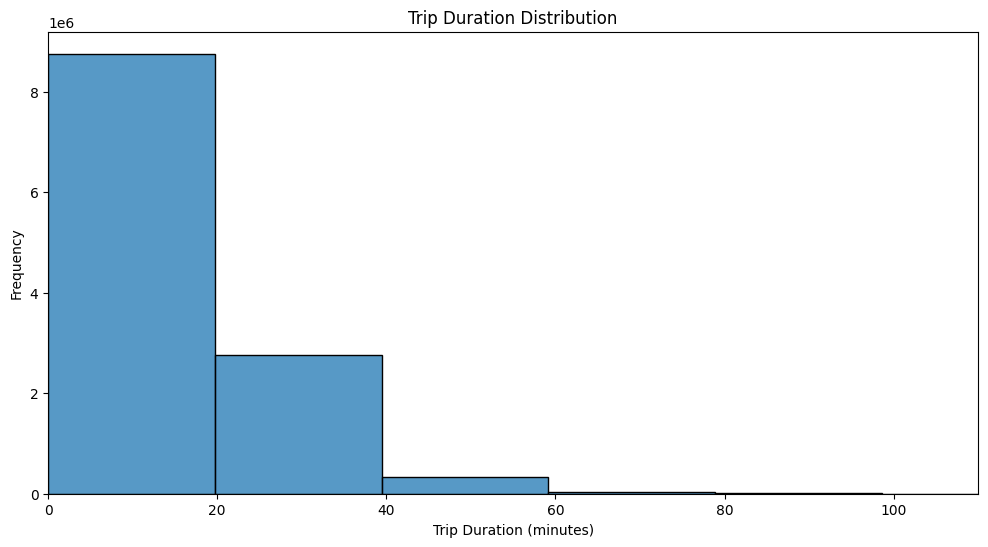

In [7]:
# Explore trip duration distribution with custom x-axis limits
plt.figure(figsize=(12, 6))
sns.histplot(trip_data['trip_duration_minutes'], bins=50)
plt.title('Trip Duration Distribution')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Frequency')

# Set x-axis limits
plt.xlim(0, 110)

plt.show()


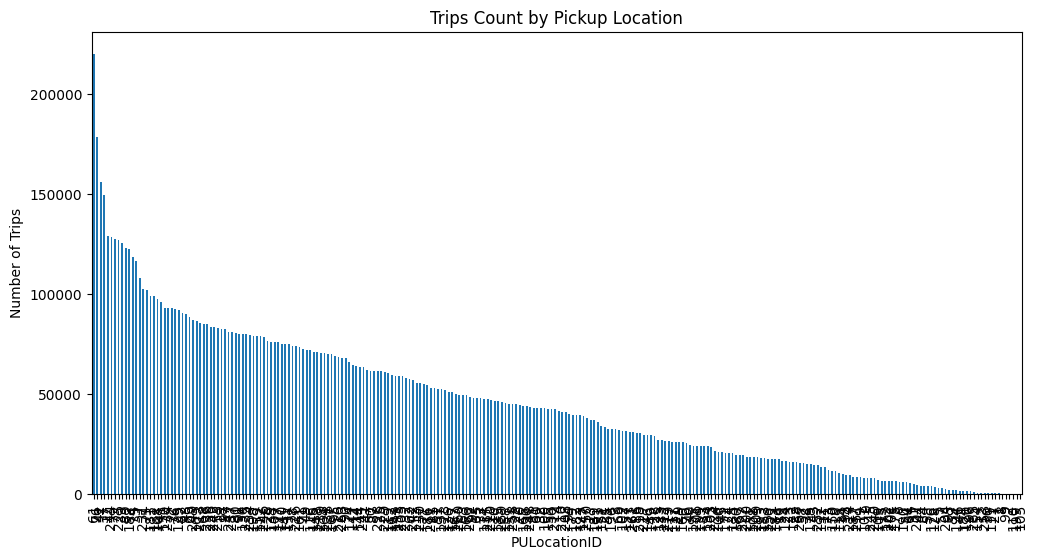

Location with the maximum trips: 61


In [15]:
import pandas as pd
import matplotlib.pyplot as plt


# Count trips per PULocationID
trip_counts = trip_data['PULocationID'].value_counts()

# Get the location ID with the maximum trips
max_trip_location = trip_counts.idxmax()

# Plot bar chart
plt.figure(figsize=(12, 6))
trip_counts.plot(kind='bar')
plt.title('Trips Count by Pickup Location')
plt.xlabel('PULocationID')
plt.ylabel('Number of Trips')
plt.xticks(rotation=90)
plt.show()

print(f"Location with the maximum trips: {max_trip_location}")


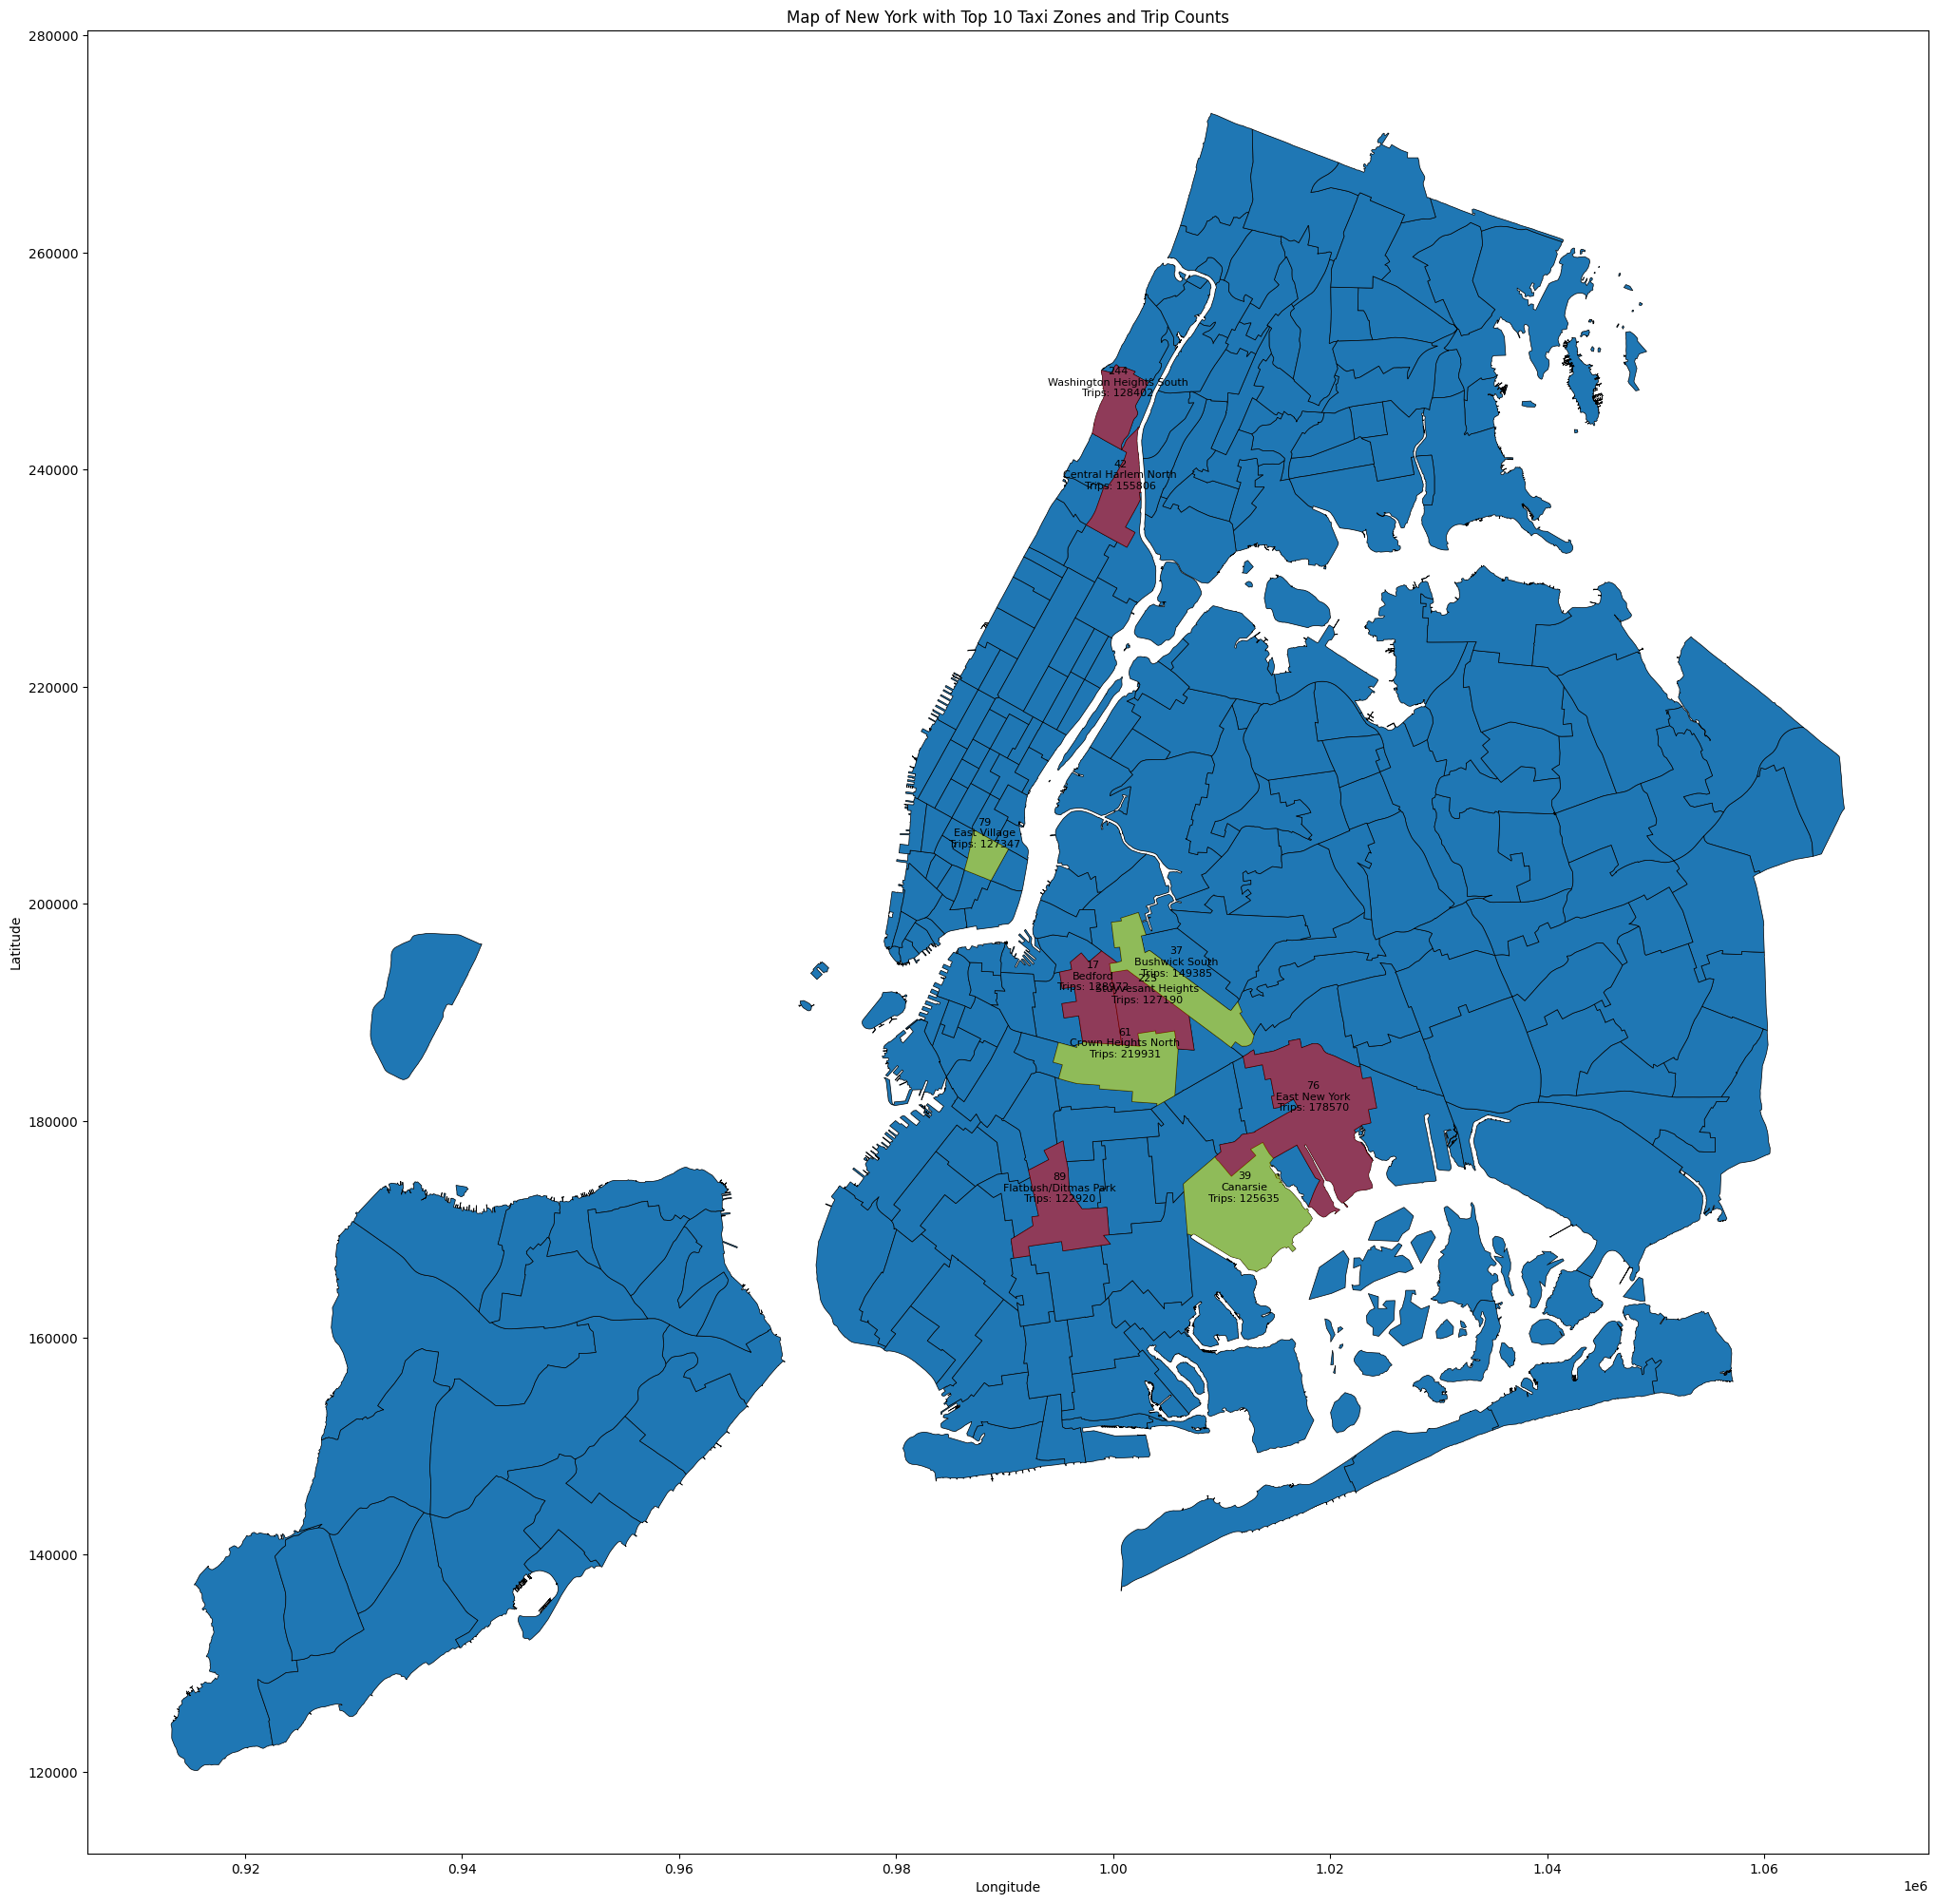

In [28]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your trip data and taxi zones shapefile

taxi_zones = gpd.read_file('taxi_zones.shp')

# Count trips per PULocationID
trip_counts = trip_data['PULocationID'].value_counts()

# Get the top 10 taxi zones by trip count
top_10_zones = trip_counts.head(10)

# Merge top 10 trip counts with taxi zones data to get names
top_10_zones_with_names = pd.merge(
    taxi_zones,
    top_10_zones,
    left_on='LocationID',
    right_index=True,
    how='right'
)

# Create a larger map with a bigger figsize
plt.figure(figsize=(25, 25))

# Plot the taxi zones boundaries
taxi_zones.plot(ax=plt.gca(), edgecolor='black', linewidth=0.5)

# Plot trip counts as text annotations for the top 10 zones
for _, row in top_10_zones_with_names.iterrows():
    centroid = row['geometry'].centroid
    plt.annotate(
        f"{row['LocationID']}\n{row['zone']}\nTrips: {row['PULocationID']}",
        (centroid.x, centroid.y),
        textcoords="offset points",
        xytext=(0, 7),
        ha='center',
        fontsize=8,
        color='black'
    )

# Color the top 10 zones as aqua or orange
for _, row in top_10_zones_with_names.iterrows():
    if row['PULocationID'] % 2 == 0:
        color = 'red'
    else:
        color = 'yellow'
    taxi_zones[taxi_zones['LocationID'] == row['LocationID']].plot(
        ax=plt.gca(),
        color=color,
        alpha=0.5
    )

plt.title('Map of New York with Top 10 Taxi Zones and Trip Counts')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()



Average trips per location: 45452.17


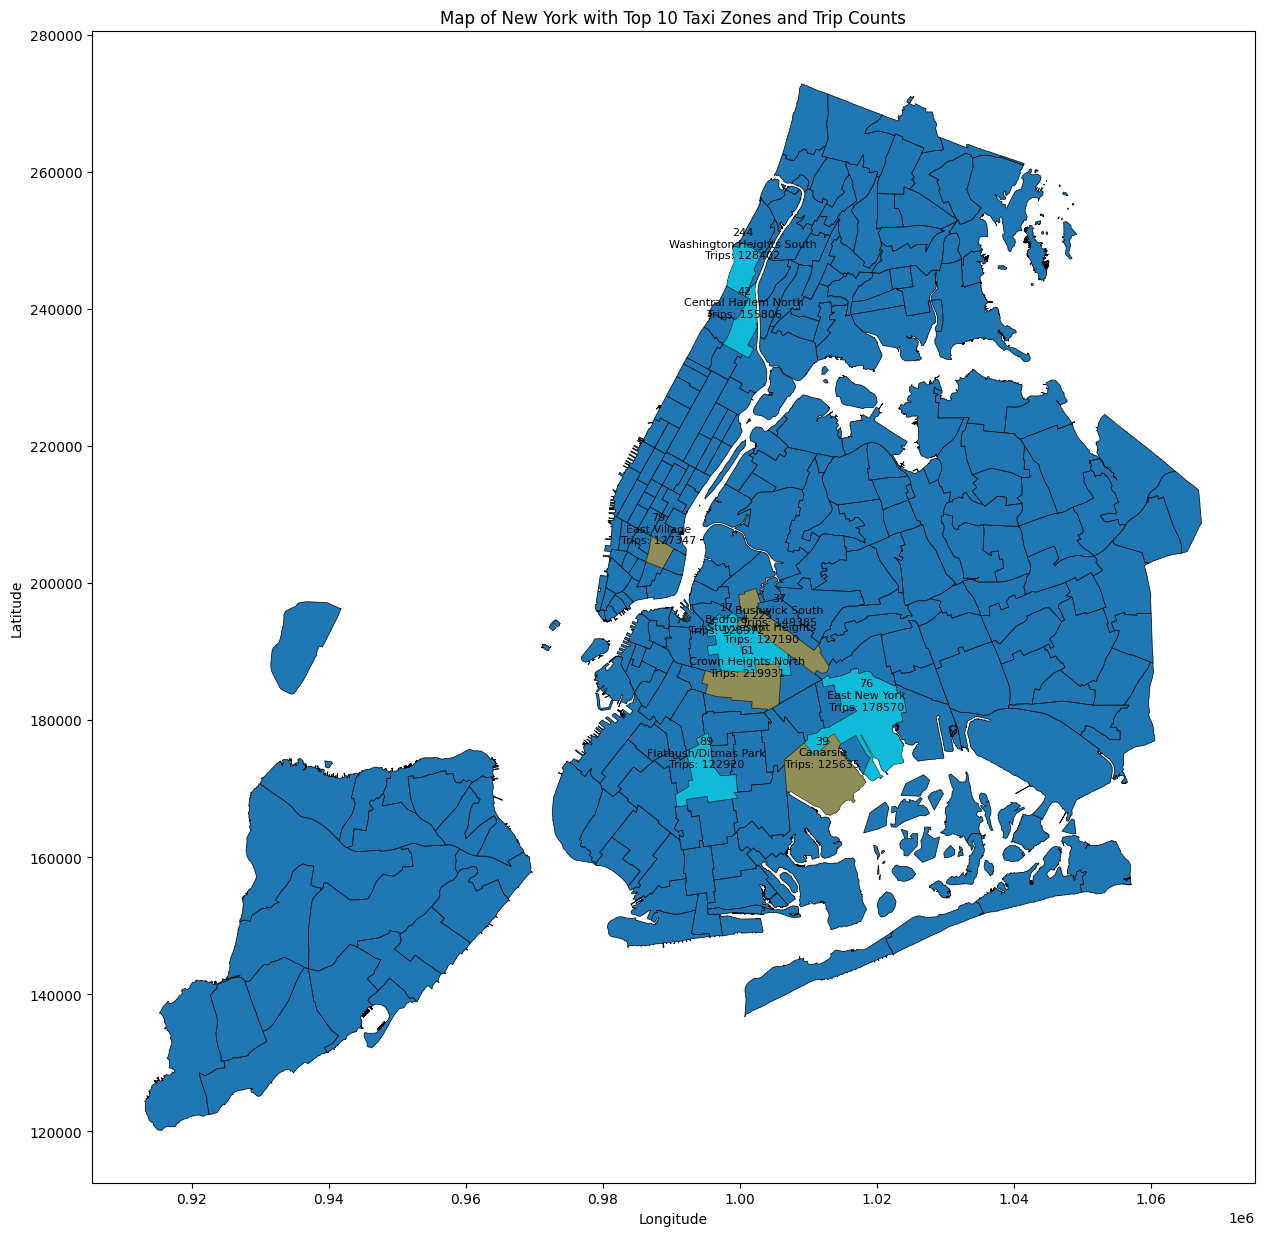

In [29]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your trip data and taxi zones shapefile

taxi_zones = gpd.read_file('taxi_zones.shp')

# Count trips per PULocationID
trip_counts = trip_data['PULocationID'].value_counts()

# Get the top 10 taxi zones by trip count
top_10_zones = trip_counts.head(10)

# Merge top 10 trip counts with taxi zones data to get names
top_10_zones_with_names = pd.merge(
    taxi_zones,
    top_10_zones,
    left_on='LocationID',
    right_index=True,
    how='right'
)

# Calculate average trips per PULocationID
avg_trips_per_location = trip_data.groupby('PULocationID')['PULocationID'].count().mean()
print(f"Average trips per location: {avg_trips_per_location:.2f}")

# Create a larger map with a bigger figsize
plt.figure(figsize=(15, 15))

# Plot the taxi zones boundaries
taxi_zones.plot(ax=plt.gca(), edgecolor='black', linewidth=0.5)

# Plot trip counts as text annotations for the top 10 zones
for _, row in top_10_zones_with_names.iterrows():
    centroid = row['geometry'].centroid
    plt.annotate(
        f"{row['LocationID']}\n{row['zone']}\nTrips: {row['PULocationID']}",
        (centroid.x, centroid.y),
        textcoords="offset points",
        xytext=(0, 7),
        ha='center',
        fontsize=8,
        color='black'
    )

# Color the top 10 zones as aqua or orange
for _, row in top_10_zones_with_names.iterrows():
    if row['PULocationID'] % 2 == 0:
        color = 'aqua'
    else:
        color = 'orange'
    taxi_zones[taxi_zones['LocationID'] == row['LocationID']].plot(
        ax=plt.gca(),
        color=color,
        alpha=0.5
    )

plt.title('Map of New York with Top 10 Taxi Zones and Trip Counts')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


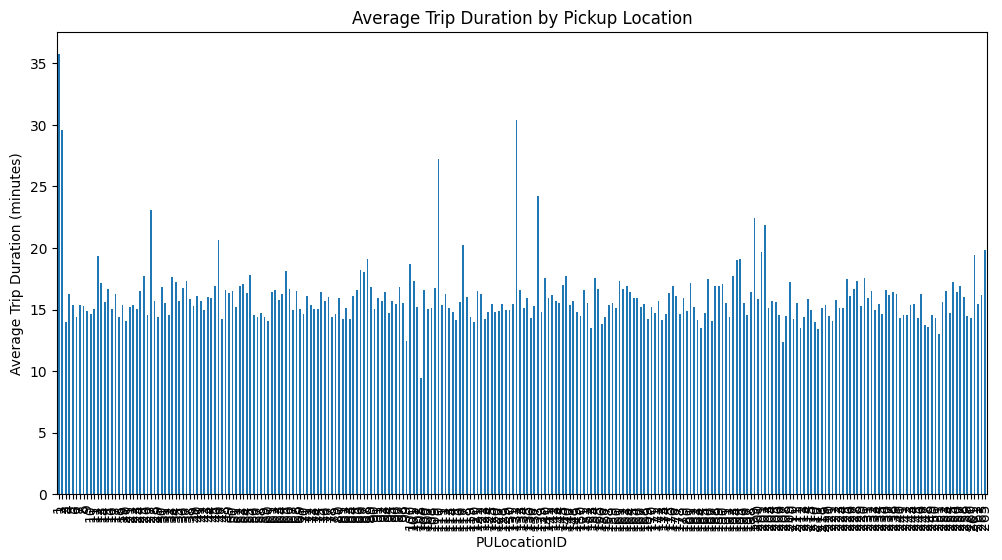

In [30]:
# Assuming you have a column named 'trip_duration_minutes' for trip duration

# Calculate average trip duration per PULocationID
avg_duration_per_location = trip_data.groupby('PULocationID')['trip_duration_minutes'].mean()

# Plot bar chart
plt.figure(figsize=(12, 6))
avg_duration_per_location.plot(kind='bar')
plt.title('Average Trip Duration by Pickup Location')
plt.xlabel('PULocationID')
plt.ylabel('Average Trip Duration (minutes)')
plt.xticks(rotation=90)
plt.show()


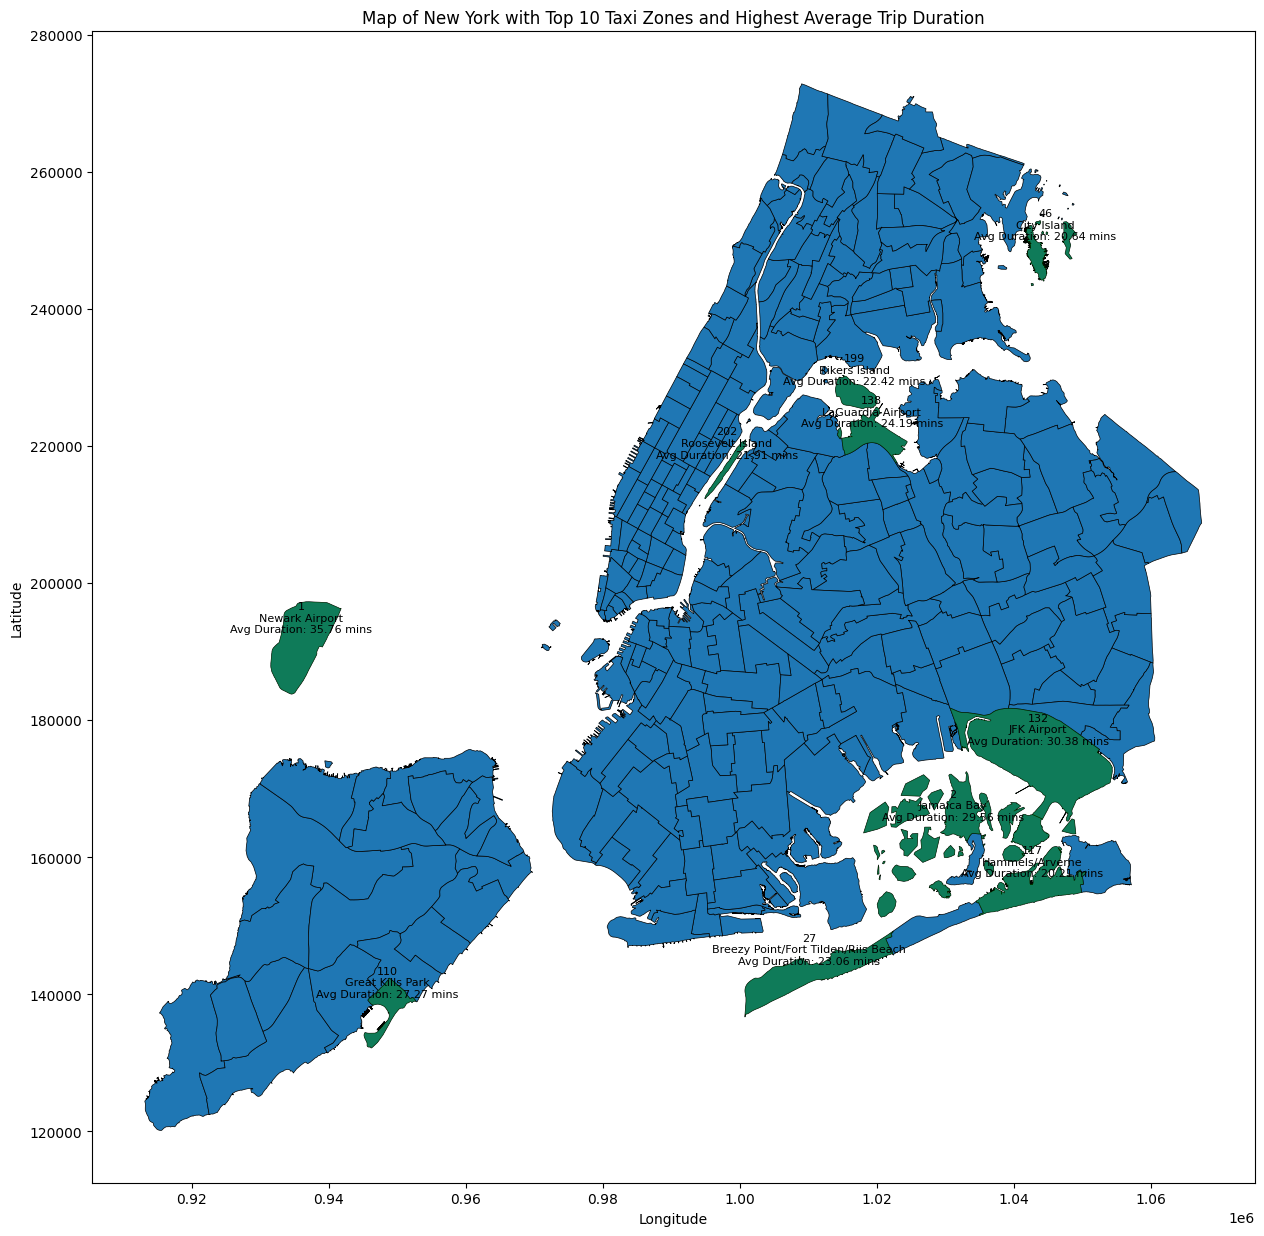

In [32]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your trip data and taxi zones shapefile

taxi_zones = gpd.read_file('taxi_zones.shp')

# Calculate average trip duration per PULocationID
avg_duration_per_location = trip_data.groupby('PULocationID')['trip_duration_minutes'].mean()

# Get the top 10 taxi zones by average trip duration
top_10_duration_zones = avg_duration_per_location.nlargest(10)

# Merge top 10 average trip duration with taxi zones data to get names
top_10_duration_zones_with_names = pd.merge(
    taxi_zones,
    top_10_duration_zones,
    left_on='LocationID',
    right_index=True,
    how='right'
)

# Create a larger map with a bigger figsize
plt.figure(figsize=(15, 15))

# Plot the taxi zones boundaries
taxi_zones.plot(ax=plt.gca(), edgecolor='black', linewidth=0.5)

# Plot average trip duration as text annotations for the top 10 zones
for _, row in top_10_duration_zones_with_names.iterrows():
    centroid = row['geometry'].centroid
    plt.annotate(
        f"{row['LocationID']}\n{row['zone']}\nAvg Duration: {row['trip_duration_minutes']:.2f} mins",
        (centroid.x, centroid.y),
        textcoords="offset points",
        xytext=(0, 7),
        ha='center',
        fontsize=8,
        color='black'
    )

# Color the top 10 duration zones as green
for _, row in top_10_duration_zones_with_names.iterrows():
    color = 'green'
    taxi_zones[taxi_zones['LocationID'] == row['LocationID']].plot(
        ax=plt.gca(),
        color=color,
        alpha=0.5
    )

plt.title('Map of New York with Top 10 Taxi Zones and Highest Average Trip Duration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


High Duration Zones

In [34]:
high_duration_zones = avg_duration_per_location.nlargest(10)
print("Top 10 High-Duration Zones:")
for location_id, avg_duration in high_duration_zones.items():
    zone_name = taxi_zones[taxi_zones['LocationID'] == location_id]['zone'].values[0]
    print(f"LocationID: {location_id}, Zone: {zone_name}, Avg Duration: {avg_duration:.2f} mins")


Top 10 High-Duration Zones:
LocationID: 1, Zone: Newark Airport, Avg Duration: 35.76 mins
LocationID: 132, Zone: JFK Airport, Avg Duration: 30.38 mins
LocationID: 2, Zone: Jamaica Bay, Avg Duration: 29.56 mins
LocationID: 110, Zone: Great Kills Park, Avg Duration: 27.27 mins
LocationID: 138, Zone: LaGuardia Airport, Avg Duration: 24.19 mins
LocationID: 27, Zone: Breezy Point/Fort Tilden/Riis Beach, Avg Duration: 23.06 mins
LocationID: 199, Zone: Rikers Island, Avg Duration: 22.42 mins
LocationID: 202, Zone: Roosevelt Island, Avg Duration: 21.91 mins
LocationID: 46, Zone: City Island, Avg Duration: 20.64 mins
LocationID: 117, Zone: Hammels/Arverne, Avg Duration: 20.21 mins


Popular pickup locations

In [35]:
popular_pickup_zones = trip_counts.nlargest(10)
print("Top 10 Popular Pickup Zones:")
for location_id, trip_count in popular_pickup_zones.items():
    zone_name = taxi_zones[taxi_zones['LocationID'] == location_id]['zone'].values[0]
    print(f"LocationID: {location_id}, Zone: {zone_name}, Trip Count: {trip_count}")


Top 10 Popular Pickup Zones:
LocationID: 61, Zone: Crown Heights North, Trip Count: 219931
LocationID: 76, Zone: East New York, Trip Count: 178570
LocationID: 42, Zone: Central Harlem North, Trip Count: 155806
LocationID: 37, Zone: Bushwick South, Trip Count: 149385
LocationID: 17, Zone: Bedford, Trip Count: 128972
LocationID: 244, Zone: Washington Heights South, Trip Count: 128402
LocationID: 79, Zone: East Village, Trip Count: 127347
LocationID: 225, Zone: Stuyvesant Heights, Trip Count: 127190
LocationID: 39, Zone: Canarsie, Trip Count: 125635
LocationID: 89, Zone: Flatbush/Ditmas Park, Trip Count: 122920


Business Opportunities

In [39]:
some_threshold = 90000  # Adjust threshold as needed
potential_business_zones = trip_counts[trip_counts > some_threshold]
print("Zones with Potential Business Opportunities:")
for location_id, trip_count in potential_business_zones.items():
    zone_name = taxi_zones[taxi_zones['LocationID'] == location_id]['zone'].values[0]
    print(f"LocationID: {location_id}, Zone: {zone_name}, Trip Count: {trip_count}")


Zones with Potential Business Opportunities:
LocationID: 61, Zone: Crown Heights North, Trip Count: 219931
LocationID: 76, Zone: East New York, Trip Count: 178570
LocationID: 42, Zone: Central Harlem North, Trip Count: 155806
LocationID: 37, Zone: Bushwick South, Trip Count: 149385
LocationID: 17, Zone: Bedford, Trip Count: 128972
LocationID: 244, Zone: Washington Heights South, Trip Count: 128402
LocationID: 79, Zone: East Village, Trip Count: 127347
LocationID: 225, Zone: Stuyvesant Heights, Trip Count: 127190
LocationID: 39, Zone: Canarsie, Trip Count: 125635
LocationID: 89, Zone: Flatbush/Ditmas Park, Trip Count: 122920
LocationID: 188, Zone: Prospect-Lefferts Gardens, Trip Count: 122537
LocationID: 74, Zone: East Harlem North, Trip Count: 118566
LocationID: 35, Zone: Brownsville, Trip Count: 116312
LocationID: 7, Zone: Astoria, Trip Count: 108060
LocationID: 231, Zone: TriBeCa/Civic Center, Trip Count: 102600
LocationID: 75, Zone: East Harlem South, Trip Count: 101852
LocationID: 

User Preference

In [45]:
short_trip_threshold = 14  # Adjust threshold as needed
short_trip_zones = avg_duration_per_location[avg_duration_per_location < short_trip_threshold]

print("Zones with Short Trips:")
for location_id, avg_duration in short_trip_zones.items():
    zone_data = taxi_zones[taxi_zones['LocationID'] == location_id]
    if not zone_data.empty:
        zone_name = zone_data['zone'].values[0]
        print(f"LocationID: {location_id}, Zone: {zone_name}, Avg Duration: {avg_duration:.2f} mins")
    else:
        print(f"LocationID: {location_id}, Zone: Not Found, Avg Duration: {avg_duration:.2f} mins")


Zones with Short Trips:
LocationID: 3, Zone: Allerton/Pelham Gardens, Avg Duration: 13.98 mins
LocationID: 99, Zone: Freshkills Park, Avg Duration: 12.48 mins
LocationID: 105, Zone: Not Found, Avg Duration: 9.47 mins
LocationID: 120, Zone: Highbridge Park, Avg Duration: 13.99 mins
LocationID: 153, Zone: Marble Hill, Avg Duration: 13.52 mins
LocationID: 156, Zone: Mariners Harbor, Avg Duration: 13.84 mins
LocationID: 184, Zone: Pelham Bay Park, Avg Duration: 13.51 mins
LocationID: 207, Zone: Saint Michaels Cemetery/Woodside, Avg Duration: 12.40 mins
LocationID: 212, Zone: Soundview/Bruckner, Avg Duration: 13.48 mins
LocationID: 216, Zone: South Ozone Park, Avg Duration: 13.96 mins
LocationID: 217, Zone: South Williamsburg, Avg Duration: 13.39 mins
LocationID: 247, Zone: West Concourse, Avg Duration: 13.76 mins
LocationID: 248, Zone: West Farms/Bronx River, Avg Duration: 13.59 mins
LocationID: 251, Zone: Westerleigh, Avg Duration: 13.02 mins


**Feature Extraction**

Temporal Features:
What was the response time to an Uber request?

In [3]:
import pandas as pd

# Assuming you have columns 'request_datetime' and 'pickup_datetime' in your DataFrame
trip_data['request_datetime'] = pd.to_datetime(trip_data['request_datetime'])
trip_data['pickup_datetime'] = pd.to_datetime(trip_data['pickup_datetime'])

# Calculate time difference in minutes
trip_data['response_time_minutes'] = (trip_data['pickup_datetime'] - trip_data['request_datetime']).dt.total_seconds() / 60

# Now you have a new column 'response_time_minutes' representing the time taken to respond to requests


In [4]:
import pandas as pd

# Assuming you have columns 'request_datetime' and 'pickup_datetime' in your DataFrame
trip_data['request_datetime'] = pd.to_datetime(trip_data['request_datetime'])
trip_data['pickup_datetime'] = pd.to_datetime(trip_data['pickup_datetime'])

# Calculate time difference in minutes
trip_data['response_time_minutes'] = (trip_data['pickup_datetime'] - trip_data['request_datetime']).dt.total_seconds() / 60

# Get the 10 slowest and 10 fastest response time areas
slowest_areas = trip_data.nlargest(10, 'response_time_minutes')
fastest_areas = trip_data.nsmallest(10, 'response_time_minutes')

# Display slowest and fastest response time areas
print("Slowest Response Time Areas:")
print(slowest_areas[['PULocationID', 'response_time_minutes']])

print("\nFastest Response Time Areas:")
print(fastest_areas[['PULocationID', 'response_time_minutes']])


Slowest Response Time Areas:
          PULocationID  response_time_minutes
5778350             79            1465.566667
421239             139            1194.816667
5643000             29             704.083333
4709510            165             682.200000
4702492            143             643.383333
3978351            165             425.250000
1654510             47             352.133333
10159816           123             335.816667
5979628             47             263.000000
247799             135             195.316667

Fastest Response Time Areas:
          PULocationID  response_time_minutes
8811452             25             -21.100000
9765309            201             -20.233333
1325957            206             -19.333333
4698642            234             -18.850000
58230              241             -18.600000
10592033           217             -18.533333
4498125            233             -18.500000
5739663            198             -18.133333
1065477             7